# Initial calibration

### Setup

In [1]:
import logging, logging.config
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pickle
import numpy as np
import pandas as pd
import pystan
import yaml

from simulation_utils.preference import generate_ibp_itemwise, records2frame
from simulation_utils.observation import sample_popular_n
from simulation_utils.utils import truncated_beta_binomial, truncated_pareto, compile_stan_model
from simulation_utils.preference import generate_ibp_nbp
from simulation_utils.datasets import ml_100k

import simulation_utils as sims_utils
%matplotlib inline

### Read data

In [2]:
data = ml_100k()
nusers = len(data['user'].unique())
nitems = len(data['item'].unique())

In [3]:
print(nusers, nitems)

943 1682


In [4]:
data.head()

user  item  rating
0   196   242       3
1   186   302       3
2    22   377       1
3   244    51       2
4   166   346       1

In [5]:
def generate_ibp_df(nusers, alpha, c=1, sigma=0):
    items = generate_ibp_itemwise(nusers, alpha, c, sigma)
    df = records2frame(items, 'item', 'user').reindex(columns=['user', 'item'])
    return df

In [6]:
def generate_ibp_rowwise(nusers, alpha, c=1, sigma=0):
    users = generate_ibp_nbp(nusers, alpha, c, sigma)
    df = records2frame(users)
    return df

In [7]:
# def truncated_poisson(lam, size=None):
#     k = np.ones(size)
#     t = np.exp(-lam) / (1 - np.exp(-lam)) * lam
#     s = t
#     u = np.random.random(size)
#     condition = s < u
#     while any(condition):
#         k[condition] = k[condition] + 1
#         t = t * lam / k
#         s = s + t
#         condition = s < u
#     return k

In [8]:
# def truncated_pareto(b, loc=0, scale=1, size=1, random_state=None):
#     pareto_rvs = pareto.rvs(b, loc, scale, size, random_state=random_state)
#     return pareto_rvs.astype(np.int64)

### Check point

In [9]:
import os
import re

In [10]:
pattern = re.compile('eval_results_2019-02-08.*.pkl')
filenames = [fn for fn in os.listdir('build') if pattern.match(fn)]

In [11]:
filenames

['eval_results_2019-02-08-02-18-11.pkl',
 'eval_results_2019-02-08-00-05-55.pkl',
 'eval_results_2019-02-08-13-07-31.pkl']

In [12]:
results = []
for fn in filenames:
    path = os.path.join('build', fn)
    with open(path, 'rb') as f:
        result = pickle.load(f)
    results.extend(result)

In [13]:
res_df = pd.DataFrame(results)

In [14]:
res_df.head()

item_popularity_kl_divergence               obs     obs_a  obs_alpha  \
0                       0.249333  sample_popular_n       NaN   0.510528   
1                       0.233655  sample_popular_n  0.000017        NaN   
2                       0.248569  sample_popular_n       NaN   0.510528   
3                       0.204463  sample_popular_n  0.000017        NaN   
4                       0.231600  sample_popular_n       NaN   0.510528   

      obs_b            obs_dist_func  obs_m  obs_n  obs_use_cap  \
0       NaN         truncated_pareto   20.0    NaN         True   
1  2.815789  truncated_beta_binomial    NaN  737.0         True   
2       NaN         truncated_pareto   20.0    NaN         True   
3  2.815789  truncated_beta_binomial    NaN  737.0         True   
4       NaN         truncated_pareto   20.0    NaN         True   

              pref  pref_alpha  pref_c  pref_nusers  pref_sigma  \
0  generate_ibp_df   85.108065     1.0          943    0.000000   
1  generate_ibp_df   85.108065     1.0          943    0.000000   
2  generate_ibp_df   85.108065     1.0          943    0.042403   
3  generate_ibp_df   85.108065     1.0          943    0.042403   
4  generate_ibp_df   85.108065     1.0          943    0.092656   

   user_activity_kl_divergence  
0                     0.411168  
1                     0.453102  
2                     0.399515  
3                     0.457729  
4                     0.389943

In [15]:
res_df.shape

(27720, 15)

In [20]:
res_df[res_df['item_popularity_kl_divergence'] < 2].sort_values(['item_popularity_kl_divergence', 'user_activity_kl_divergence']).iloc[40:100]

item_popularity_kl_divergence               obs     obs_a  obs_alpha  \
10629                       0.164590  sample_popular_n  0.000017        NaN   
20793                       0.164620  sample_popular_n  0.000017        NaN   
19891                       0.164734  sample_popular_n  0.000017        NaN   
21297                       0.164901  sample_popular_n  0.000017        NaN   
22640                       0.164907  sample_popular_n       NaN   0.510528   
20331                       0.165288  sample_popular_n  0.000017        NaN   
21716                       0.165406  sample_popular_n       NaN   0.510528   
21783                       0.165480  sample_popular_n  0.000017        NaN   
22179                       0.165864  sample_popular_n  0.000017        NaN   
21759                       0.165988  sample_popular_n  0.000017        NaN   
20383                       0.167096  sample_popular_n  0.000017        NaN   
22639                       0.167505  sample_popular_n  0.000017        NaN   
10635                       0.167568  sample_popular_n  0.000017        NaN   
20339                       0.167691  sample_popular_n  0.000017        NaN   
19879                       0.168102  sample_popular_n  0.000017        NaN   
20815                       0.168237  sample_popular_n  0.000017        NaN   
21298                       0.168269  sample_popular_n       NaN   0.510528   
21719                       0.168343  sample_popular_n  0.000017        NaN   
1386                        0.168465  sample_popular_n       NaN   0.510528   
20333                       0.168515  sample_popular_n  0.000017        NaN   
11096                       0.168907  sample_popular_n       NaN   0.510528   
463                         0.168924  sample_popular_n  0.000017        NaN   
11088                       0.168945  sample_popular_n       NaN   0.510528   
21258                       0.169141  sample_popular_n       NaN   0.510528   
21275                       0.169347  sample_popular_n  0.000017        NaN   
19911                       0.169398  sample_popular_n  0.000017        NaN   
21281                       0.169469  sample_popular_n  0.000017        NaN   
11092                       0.169537  sample_popular_n       NaN   0.510528   
21721                       0.170503  sample_popular_n  0.000017        NaN   
20859                       0.170522  sample_popular_n  0.000017        NaN   
21722                       0.170922  sample_popular_n       NaN   0.510528   
11090                       0.171227  sample_popular_n       NaN   0.510528   
21782                       0.171288  sample_popular_n       NaN   0.510528   
20797                       0.171433  sample_popular_n  0.000017        NaN   
20857                       0.171492  sample_popular_n  0.000017        NaN   
21319                       0.171544  sample_popular_n  0.000017        NaN   
21724                       0.171883  sample_popular_n       NaN   0.510528   
23100                       0.172211  sample_popular_n       NaN   0.510528   
21781                       0.172541  sample_popular_n  0.000017        NaN   
21257                       0.172788  sample_popular_n  0.000017        NaN   
21299                       0.173360  sample_popular_n  0.000017        NaN   
21758                       0.173413  sample_popular_n       NaN   0.510528   
21780                       0.173561  sample_popular_n       NaN   0.510528   
21261                       0.173603  sample_popular_n  0.000017        NaN   
11091                       0.173687  sample_popular_n  0.000017        NaN   
20801                       0.173915  sample_popular_n  0.000017        NaN   
21727                       0.174111  sample_popular_n  0.000017        NaN   
19866                       0.174266  sample_popular_n       NaN   0.510528   
21278                       0.174293  sample_popular_n       NaN   0.510528   
21725                       0.174390  sample_popular_n  0

In [17]:
res_df[res_df['item_popularity_kl_divergence'] < 0.16].sort_values(['user_activity_kl_divergence', 'item_popularity_kl_divergence']).head(10)

item_popularity_kl_divergence               obs     obs_a  obs_alpha  \
21253                       0.156443  sample_popular_n  0.000017        NaN   
21255                       0.144993  sample_popular_n  0.000017        NaN   
21737                       0.149542  sample_popular_n  0.000017        NaN   
21717                       0.157712  sample_popular_n  0.000017        NaN   
20353                       0.155546  sample_popular_n  0.000017        NaN   
21736                       0.154779  sample_popular_n       NaN   0.510528   
20795                       0.150629  sample_popular_n  0.000017        NaN   
20329                       0.157004  sample_popular_n  0.000017        NaN   
20791                       0.154733  sample_popular_n  0.000017        NaN   
20835                       0.149945  sample_popular_n  0.000017        NaN   

          obs_b            obs_dist_func  obs_m  obs_n  obs_use_cap  \
21253  2.815789  truncated_beta_binomial    NaN  737.0         True   
21255  2.815789  truncated_beta_binomial    NaN  737.0         True   
21737  2.815789  truncated_beta_binomial    NaN  737.0         True   
21717  2.815789  truncated_beta_binomial    NaN  737.0         True   
20353  2.815789  truncated_beta_binomial    NaN  737.0         True   
21736       NaN         truncated_pareto   20.0    NaN         True   
20795  2.815789  truncated_beta_binomial    NaN  737.0         True   
20329  2.815789  truncated_beta_binomial    NaN  737.0         True   
20791  2.815789  truncated_beta_binomial    NaN  737.0         True   
20835  2.815789  truncated_beta_binomial    NaN  737.0         True   

                  pref  pref_alpha    pref_c  pref_nusers  pref_sigma  \
21253  generate_ibp_df  766.416914  0.706652          943    0.000000   
21255  generate_ibp_df  766.416914  0.706652          943    0.010184   
21737  generate_ibp_df  799.486970  0.910087          943    0.000000   
21717  generate_ibp_df  799.486970  0.706652          943    0.010184   
20353  generate_ibp_df  571.000707  0.910087          943    0.010184   
21736  generate_ibp_df  799.486970  0.910087          943    0.000000   
20795  generate_ibp_df  617.236159  0.706652          943    0.072258   
20329  generate_ibp_df  571.000707  0.706652          943    0.000000   
20791  generate_ibp_df  617.236159  0.706652          943    0.000000   
20835  generate_ibp_df  617.236159  1.000000          943    0.000000   

       user_activity_kl_divergence  
21253                     0.143201  
21255                     0.145071  
21737                     0.146069  
21717                     0.147877  
20353                     0.150009  
21736                     0.150067  
20795                     0.155723  
20329                     0.156218  
20791                     0.159516  
20835                     0.160706

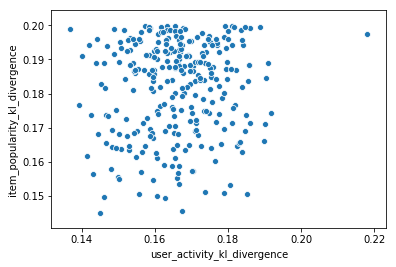

In [18]:
sns.scatterplot('user_activity_kl_divergence', 'item_popularity_kl_divergence', data=res_df[res_df['item_popularity_kl_divergence'] < 0.2])

### KL divergence vs. parameters

In [19]:
res_df_tall = res_df[['item_popularity_kl_divergence', 'obs_dist_func', 'pref_alpha', 'pref_c', 'pref_sigma', 'user_activity_kl_divergence']].melt(
    id_vars = ['obs_dist_func', 'pref_alpha', 'pref_c', 'pref_sigma'],
    value_vars=['item_popularity_kl_divergence', 'user_activity_kl_divergence'],
    var_name = 'statistics',
    value_name = 'score'
)

alpha

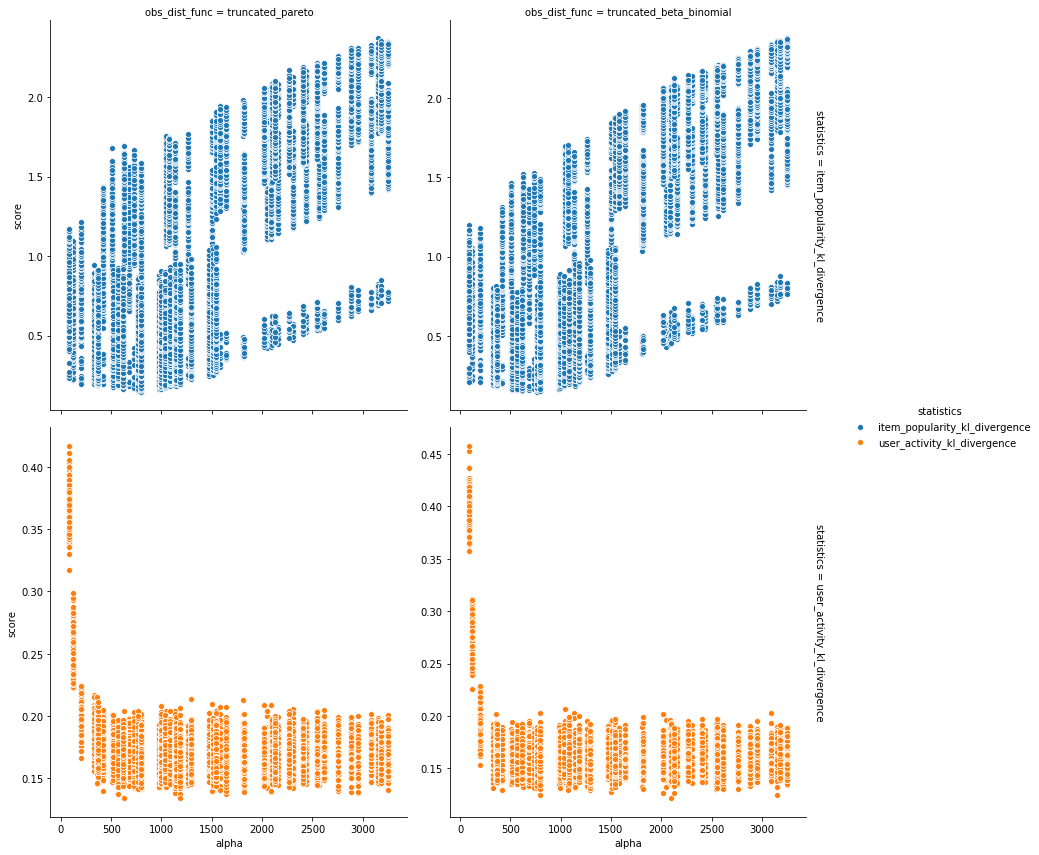

In [20]:
g = sns.FacetGrid(res_df_tall, col='obs_dist_func', hue='statistics', row='statistics', height=6, sharey=False, margin_titles=True)
g = (g.map(sns.scatterplot, 'pref_alpha', 'score')
     .add_legend()
     .set_axis_labels('alpha', 'score'))

c

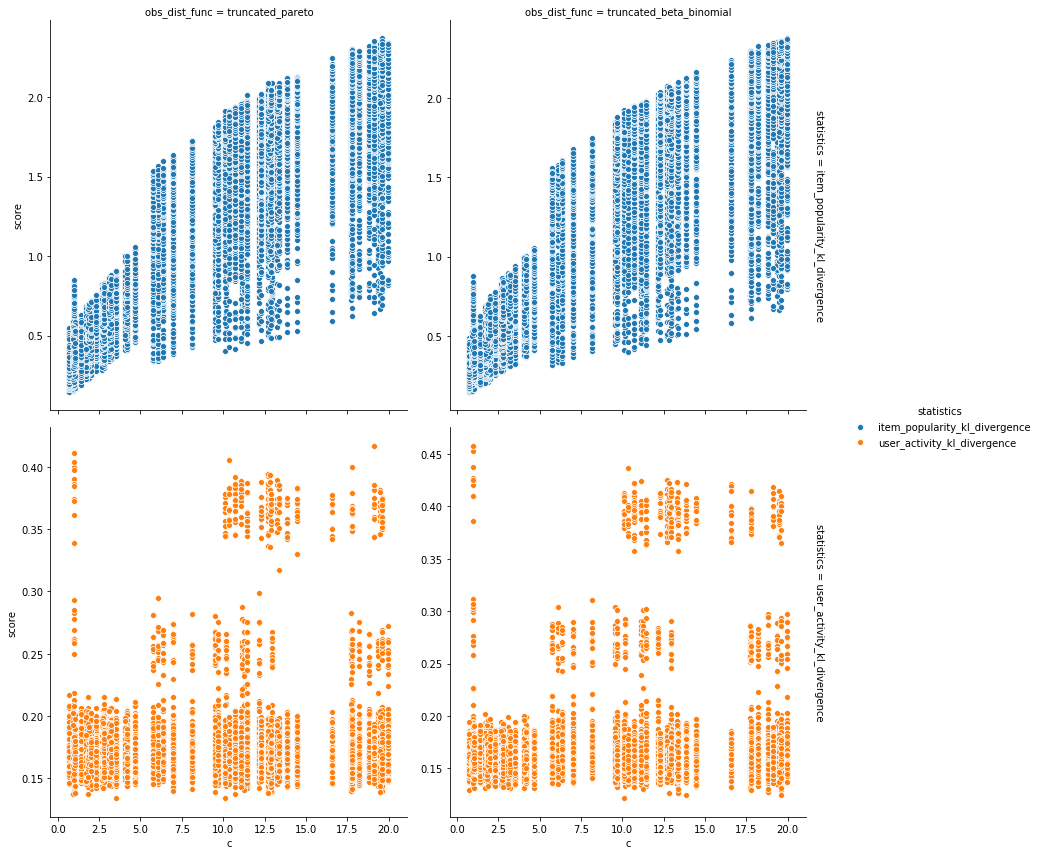

In [21]:
g = sns.FacetGrid(res_df_tall, col='obs_dist_func', hue='statistics', row='statistics', height=6, sharey=False, margin_titles=True)
g = (g.map(sns.scatterplot, 'pref_c', 'score')
     .add_legend()
     .set_axis_labels('c', 'score'))

Sigma

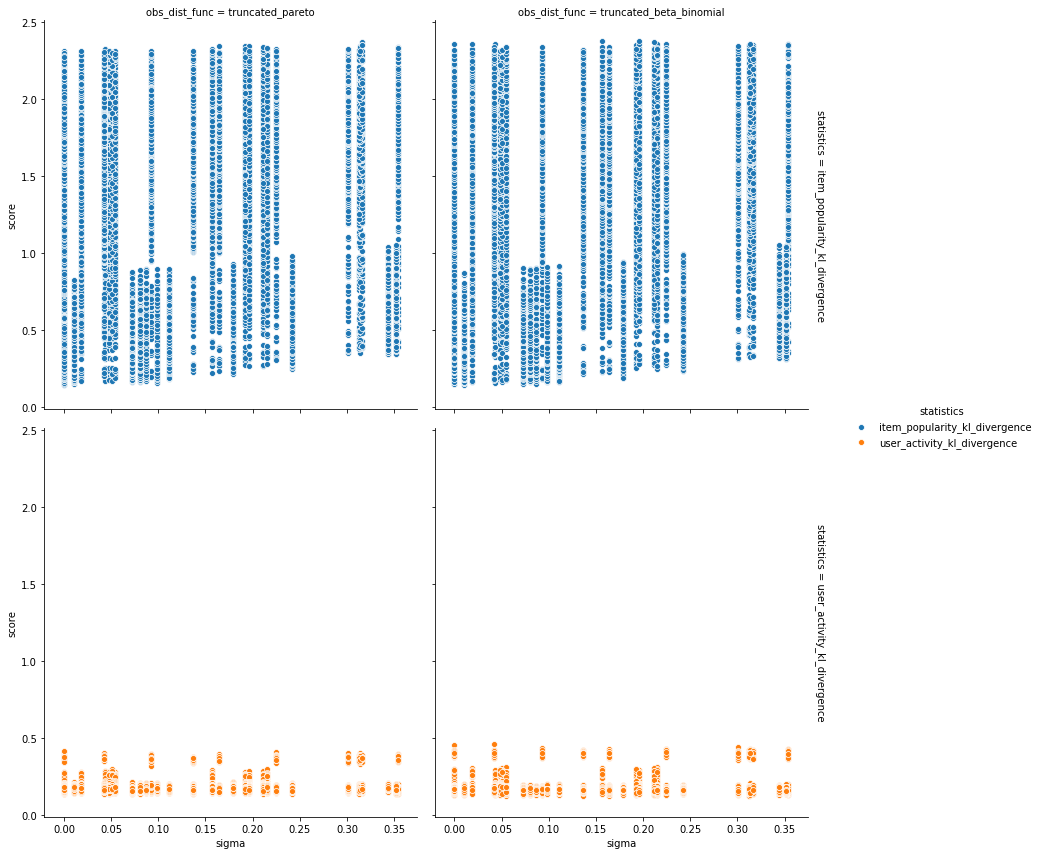

In [22]:
g = sns.FacetGrid(res_df_tall, col='obs_dist_func', hue='statistics', row='statistics', height=6, margin_titles=True)
g = (g.map(sns.scatterplot, 'pref_sigma', 'score')
     .add_legend()
     .set_axis_labels('sigma', 'score'))

In [23]:
def plot_scatter3d(x, y, z, c, **kwargs):
    ax = plt.gca()
    kwargs.pop('color')
    p = ax.scatter(x, y, z, c=c, **kwargs)
#     plt.colorbar(p, shrink=0.5, aspect=5)
    ax.set_zlabel('c')

In [25]:
cmap_name = None
cmap = plt.get_cmap(cmap_name)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(res_df_tall['score'])

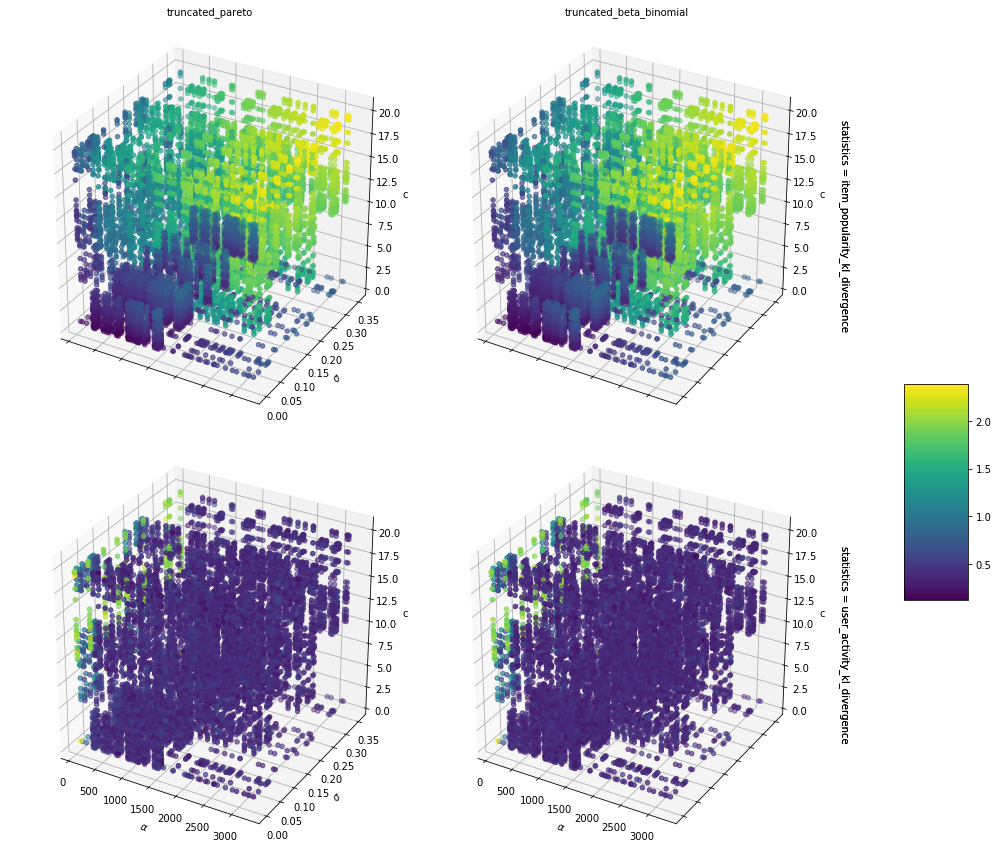

In [26]:
g = sns.FacetGrid(res_df_tall, col='obs_dist_func', row='statistics', height=6, margin_titles=True, subplot_kws=dict(projection='3d'))
g = (g.map(plot_scatter3d, 'pref_alpha', 'pref_sigma', 'pref_c', 'score', cmap=cmap)
     .set_titles(col_template='{col_name}')
     .set_axis_labels(r'$\alpha$', r'$\sigma$'))
cax = g.fig.add_axes([1.05, 0.3, 0.075, 0.25])
plt.colorbar(sm, cax=cax)

Generate simulated data using the best parameters

In [23]:
def simulated_data_bb(nusers=943, alpha=1009.2, c=0.3, sigma=0.8):
#     pref = generate_ibp_df(943, 1009.2, 0.3, 0.8)
    pref = generate_ibp_df(nusers, alpha, c, sigma)
    obs = sample_popular_n(pref, truncated_beta_binomial, True, a=1.6638872003071793e-05, b=2.8157887296158077, n=737)
    return obs

In [24]:
def simulated_data_pareto(nusers=943, alpha=799.486970, c=0.910087, sigma=0):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = generate_ibp_df(nusers, alpha, c, sigma)
    obs = sample_popular_n(pref, truncated_pareto, True, m=20.00000045, alpha=0.510528)
    return obs

In [25]:
def simulated_data(name, *args, **kwargs):
    out = None
    if 'TBB' in name:
        out = simulated_data_bb(*args, **kwargs)
    if 'TP' in name:
        out = simulated_data_pareto(*args, **kwargs)
    return out

In [26]:
# def simulated_data_geo():
#     pref = generate_ibp_df(943, 1009, 1, 0)
#     obs = sample_popular_n(pref, np.random.geometric, False, p=0.05)
#     return obs

In [27]:
def compute_density(data):
    nusers = len(data['user'].unique())
    nitems = len(data['item'].unique())
    npairs = len(data)
    density = npairs / nitems / nusers
    return nusers, nitems, npairs, density

In [28]:
def compute_data_stats(data):
    pairs = data.loc[:, ['user', 'item']]
    user_activity = pairs.groupby('user', as_index=False).count().rename(columns={'item': 'count'})
    item_popularity = pairs.groupby('item', as_index=False).count().rename(columns={'user': 'count'})
    return user_activity, item_popularity

In [29]:
def summarize_dataset(name, data_func, *args, **kwargs):
    dataset = data_func(*args, **kwargs)
    colname = dataset.columns
    if not {'user', 'item'}.issubset(colname):
        dataset.rename(columns={colname[0]: 'user',
                                colname[1]: 'item'},
                       inplace=True)
    dataset = dataset[['user', 'item']]
    data_meta = compute_density(dataset)
    data_meta_stats = tuple([name, *data_meta])
    
    user_activity, item_popularity = compute_data_stats(dataset)
    user_activity['dataset'] = name
    user_activity.drop('user', axis=1, inplace=True)
    item_popularity['dataset'] = name
    item_popularity.drop('item', axis=1, inplace=True)
    item_popularity['rank'] = item_popularity['count'].rank(method='min', ascending=False)

    user_activity_stats = user_activity['count'].rename(name).describe()
    item_popularity_stats = item_popularity['count'].rename(name).describe()
    return data_meta_stats, user_activity_stats, item_popularity_stats, user_activity, item_popularity

In [30]:
res_df['distance'] = res_df['item_popularity_kl_divergence'] ** 2 + res_df['user_activity_kl_divergence'] ** 2

In [31]:
res_df.head()

item_popularity_kl_divergence               obs     obs_a  obs_alpha  \
0                       0.238624  sample_popular_n       NaN   0.510528   
1                       0.214867  sample_popular_n  0.000017        NaN   
2                       0.230238  sample_popular_n       NaN   0.510528   
3                       0.234469  sample_popular_n  0.000017        NaN   
4                       0.221425  sample_popular_n       NaN   0.510528   

      obs_b            obs_dist_func  obs_m  obs_n  obs_use_cap  \
0       NaN         truncated_pareto   20.0    NaN         True   
1  2.815789  truncated_beta_binomial    NaN  737.0         True   
2       NaN         truncated_pareto   20.0    NaN         True   
3  2.815789  truncated_beta_binomial    NaN  737.0         True   
4       NaN         truncated_pareto   20.0    NaN         True   

              pref  pref_alpha  pref_c  pref_nusers  pref_sigma  \
0  generate_ibp_df   122.89334     1.0          943    0.000000   
1  generate_ibp_df   122.89334     1.0          943    0.000000   
2  generate_ibp_df   122.89334     1.0          943    0.018104   
3  generate_ibp_df   122.89334     1.0          943    0.018104   
4  generate_ibp_df   122.89334     1.0          943    0.043073   

   user_activity_kl_divergence  distance  
0                     0.261609  0.125381  
1                     0.267565  0.117758  
2                     0.261982  0.121644  
3                     0.257847  0.121461  
4                     0.282238  0.128687

In [32]:
res_params = res_df[['obs_dist_func', 'pref_nusers', 'pref_alpha', 'pref_c', 'pref_sigma', 'item_popularity_kl_divergence', 'user_activity_kl_divergence', 'distance']]

In [33]:
NPARAMS = 10
ip_params = res_params.sort_values(['obs_dist_func', 'item_popularity_kl_divergence']).groupby('obs_dist_func').head(NPARAMS)
ua_params = res_params.sort_values(['obs_dist_func', 'user_activity_kl_divergence']).groupby('obs_dist_func').head(NPARAMS)
d_params = res_params.sort_values(['obs_dist_func', 'distance']).groupby('obs_dist_func').head(NPARAMS)

In [34]:
from itertools import repeat

In [42]:
def summarize_datasets(params):
    from multiprocessing import Pool
    params = params.join(params.groupby('obs_dist_func').cumcount().rename('param_no'))
    params['name'] = params['obs_dist_func'].map(lambda x: ''.join(next(zip(*x.split('_')))).upper()) + params['param_no'].map(str)
    params = zip(params['name'].values, repeat(simulated_data), 
                 *params[['name', 'pref_nusers', 'pref_alpha', 'pref_c', 'pref_sigma']].to_dict('list').values()) 
    with Pool(10) as p:
        results = p.starmap(summarize_dataset, params)
    simulated_results = zip(*results)
    ml_100k_results = summarize_dataset('ml_100k', ml_100k)
    df = pd.DataFrame.from_records([ml_100k_results[0], *next(simulated_results)],
                               columns=['dataset', 'nusers', 'nitems', 'npairs', 'density'])
    print('dataset stats')
    print(df)

    df = pd.concat([ml_100k_results[1], *next(simulated_results)], axis=1)
    print('user profile stats')
    print(df)

    df = pd.concat([ml_100k_results[2], *next(simulated_results)], axis=1)
    print('item popularity stats')
    print(df)

    user_profile_df = pd.concat(next(simulated_results), axis=0, ignore_index=True)

    item_popularity_df = pd.concat(next(simulated_results), axis=0, ignore_index=True)
    return ml_100k_results[3:], user_profile_df, item_popularity_df

#### Top10 parameters sorted by item popularity KL

In [43]:
ml_100k_results, user_profile_df, item_popularity_df = summarize_datasets(ip_params)

dataset stats
    dataset  nusers  nitems  npairs   density
0   ml_100k     943    1682  100000  0.063047
1      TBB0     943    2036  101999  0.053126
2      TBB1     943    2006  101999  0.053920
3      TBB2     943    2428  101999  0.044549
4      TBB3     943    2070  101999  0.052253
5      TBB4     943    1945  101999  0.055612
6      TBB5     943    2088  101999  0.051803
7      TBB6     943    1985  101999  0.054491
8      TBB7     943    1695  101999  0.063814
9      TBB8     943    1832  101950  0.059013
10     TBB9     943    1941  101992  0.055722
11      TP0     943    2174  114339  0.055773
12      TP1     943    2528  105092  0.044084
13      TP2     943    2613  115521  0.046882
14      TP3     943    2069  110435  0.056602
15      TP4     943    2552  114329  0.047508
16      TP5     943    2162  112318  0.055091
17      TP6     943    2476  107517  0.046048
18      TP7     943    2677  122187  0.048402
19      TP8     943    2681  111677  0.044173
20      TP9     943 

In [55]:
def plot_scatter_against_baseline(*args, **kwargs):
    data = pd.concat(args, axis=1)
    data['dataset'] = kwargs.get('label')
    base = kwargs.pop('baseline')
    data = data.append(base[data.columns], ignore_index=True)
    args = map(lambda x: x.name, args)
    kwargs['label'] = data['dataset'].unique()
    ax = sns.scatterplot(*args, data=data, **kwargs)
    return ax

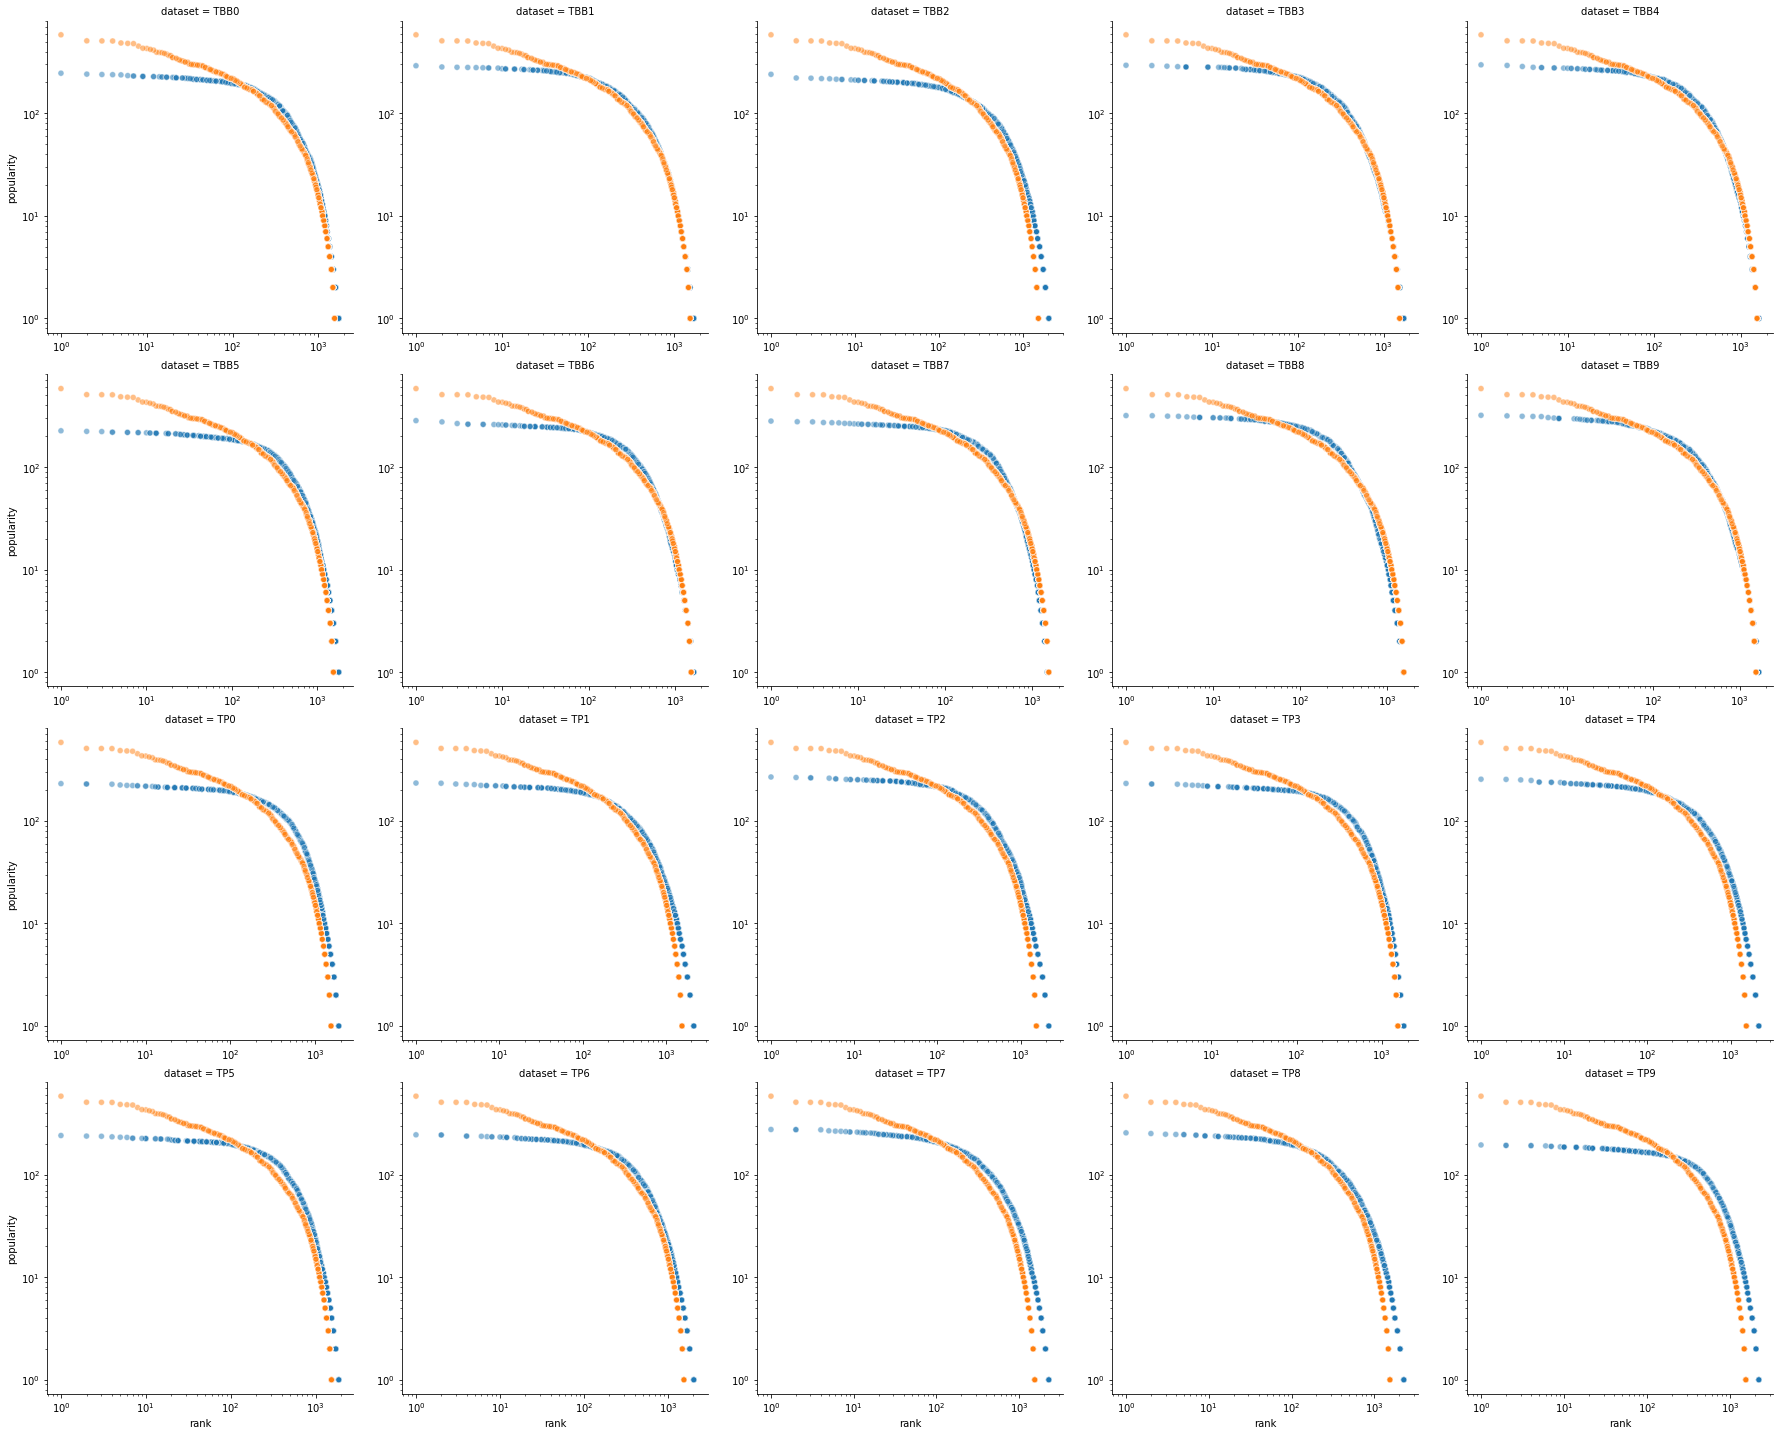

In [56]:
g = sns.FacetGrid(item_popularity_df, col='dataset', hue='dataset', sharex=False, sharey=False, col_wrap=5, height=5)
g = (g.map(plot_scatter_against_baseline, 'rank', 'count', hue='dataset', alpha=0.5, baseline=ml_100k_results[1])
     .set(xscale='log', yscale='log')
     .set_axis_labels('rank', 'popularity'))

In [59]:
popularity_counts = (item_popularity_df[['dataset', 'count']].groupby(['dataset', 'count'])
                     .size().reset_index().rename(columns={'count': 'popularity', 0: 'count'}))
ml_100k_pop_counts = (ml_100k_results[1][['dataset', 'count']].groupby(['dataset', 'count'])
                      .size().reset_index().rename(columns={'count': 'popularity', 0: 'count'}))

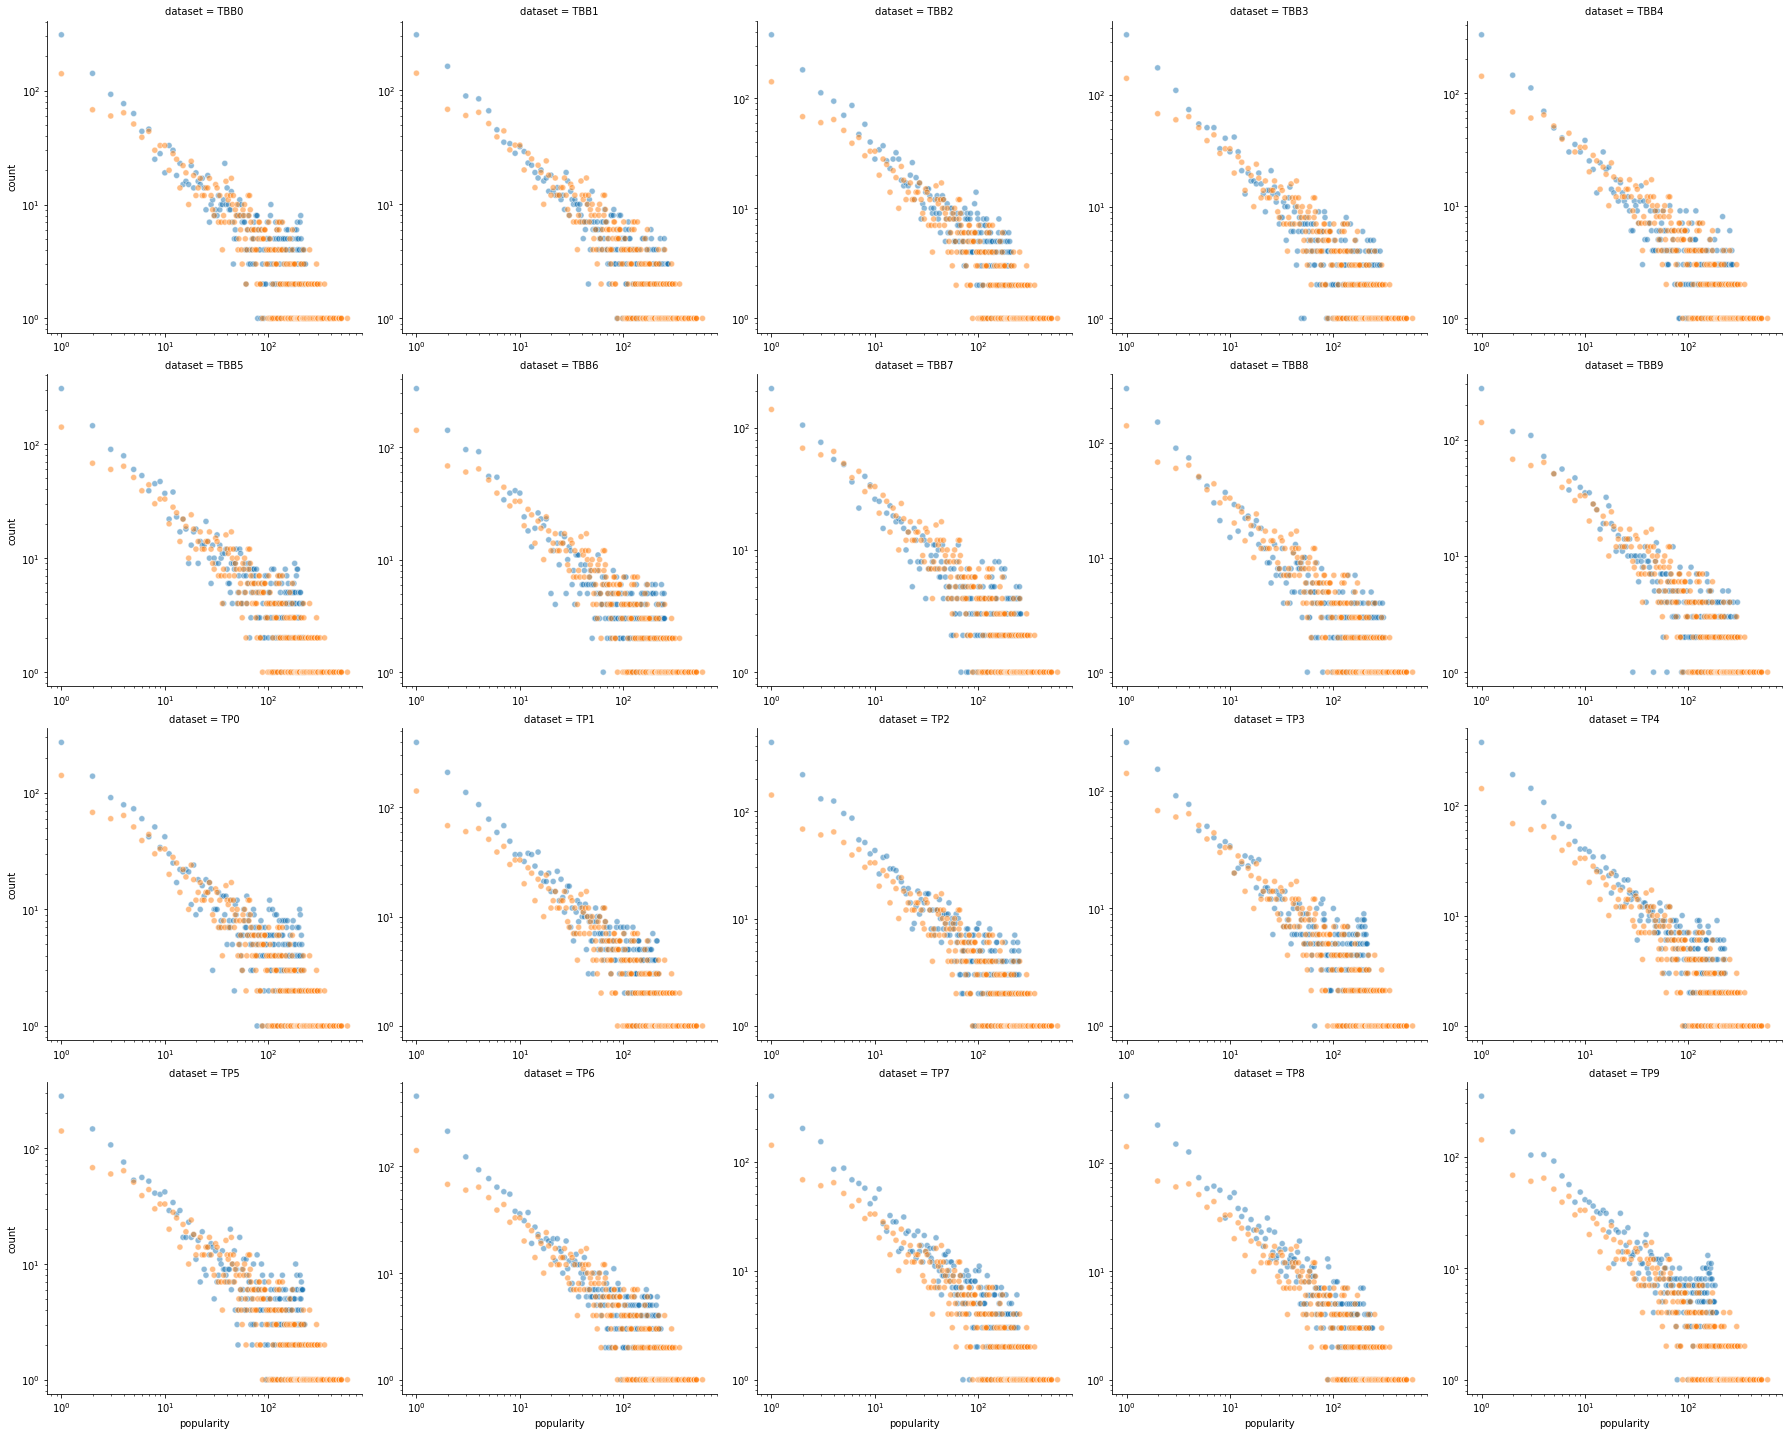

In [62]:
g = sns.FacetGrid(popularity_counts, col='dataset', hue='dataset', sharex=False, sharey=False, col_wrap=5, height=5)
g = (g.map(plot_scatter_against_baseline, 'popularity', 'count', hue='dataset', alpha=0.5, baseline=ml_100k_pop_counts)
     .set(xscale='log', yscale='log'))

#### Top10 parameters sorted by user activity KL

In [63]:
ml_100k_results, user_profile_df, item_popularity_df = summarize_datasets(ua_params)

dataset stats
    dataset  nusers  nitems  npairs   density
0   ml_100k     943    1682  100000  0.063047
1      TBB0     943   21265  101999  0.005086
2      TBB1     943   30282  101999  0.003572
3      TBB2     943   18013  101999  0.006005
4      TBB3     943   25314  101999  0.004273
5      TBB4     943   24968  101999  0.004332
6      TBB5     943   25785  101999  0.004195
7      TBB6     943   16726  100758  0.006388
8      TBB7     943    3150  101999  0.034338
9      TBB8     943   20747  101999  0.005213
10     TBB9     943   25951  101999  0.004168
11      TP0     943    9628  114781  0.012642
12      TP1     943   11534  110531  0.010162
13      TP2     943   19564  103801  0.005626
14      TP3     943    5563  118219  0.022535
15      TP4     943    2569  107867  0.044526
16      TP5     943   32183  112942  0.003721
17      TP6     943    5546  116358  0.022249
18      TP7     943    5784  110117  0.020189
19      TP8     943   22637  115085  0.005391
20      TP9     943 

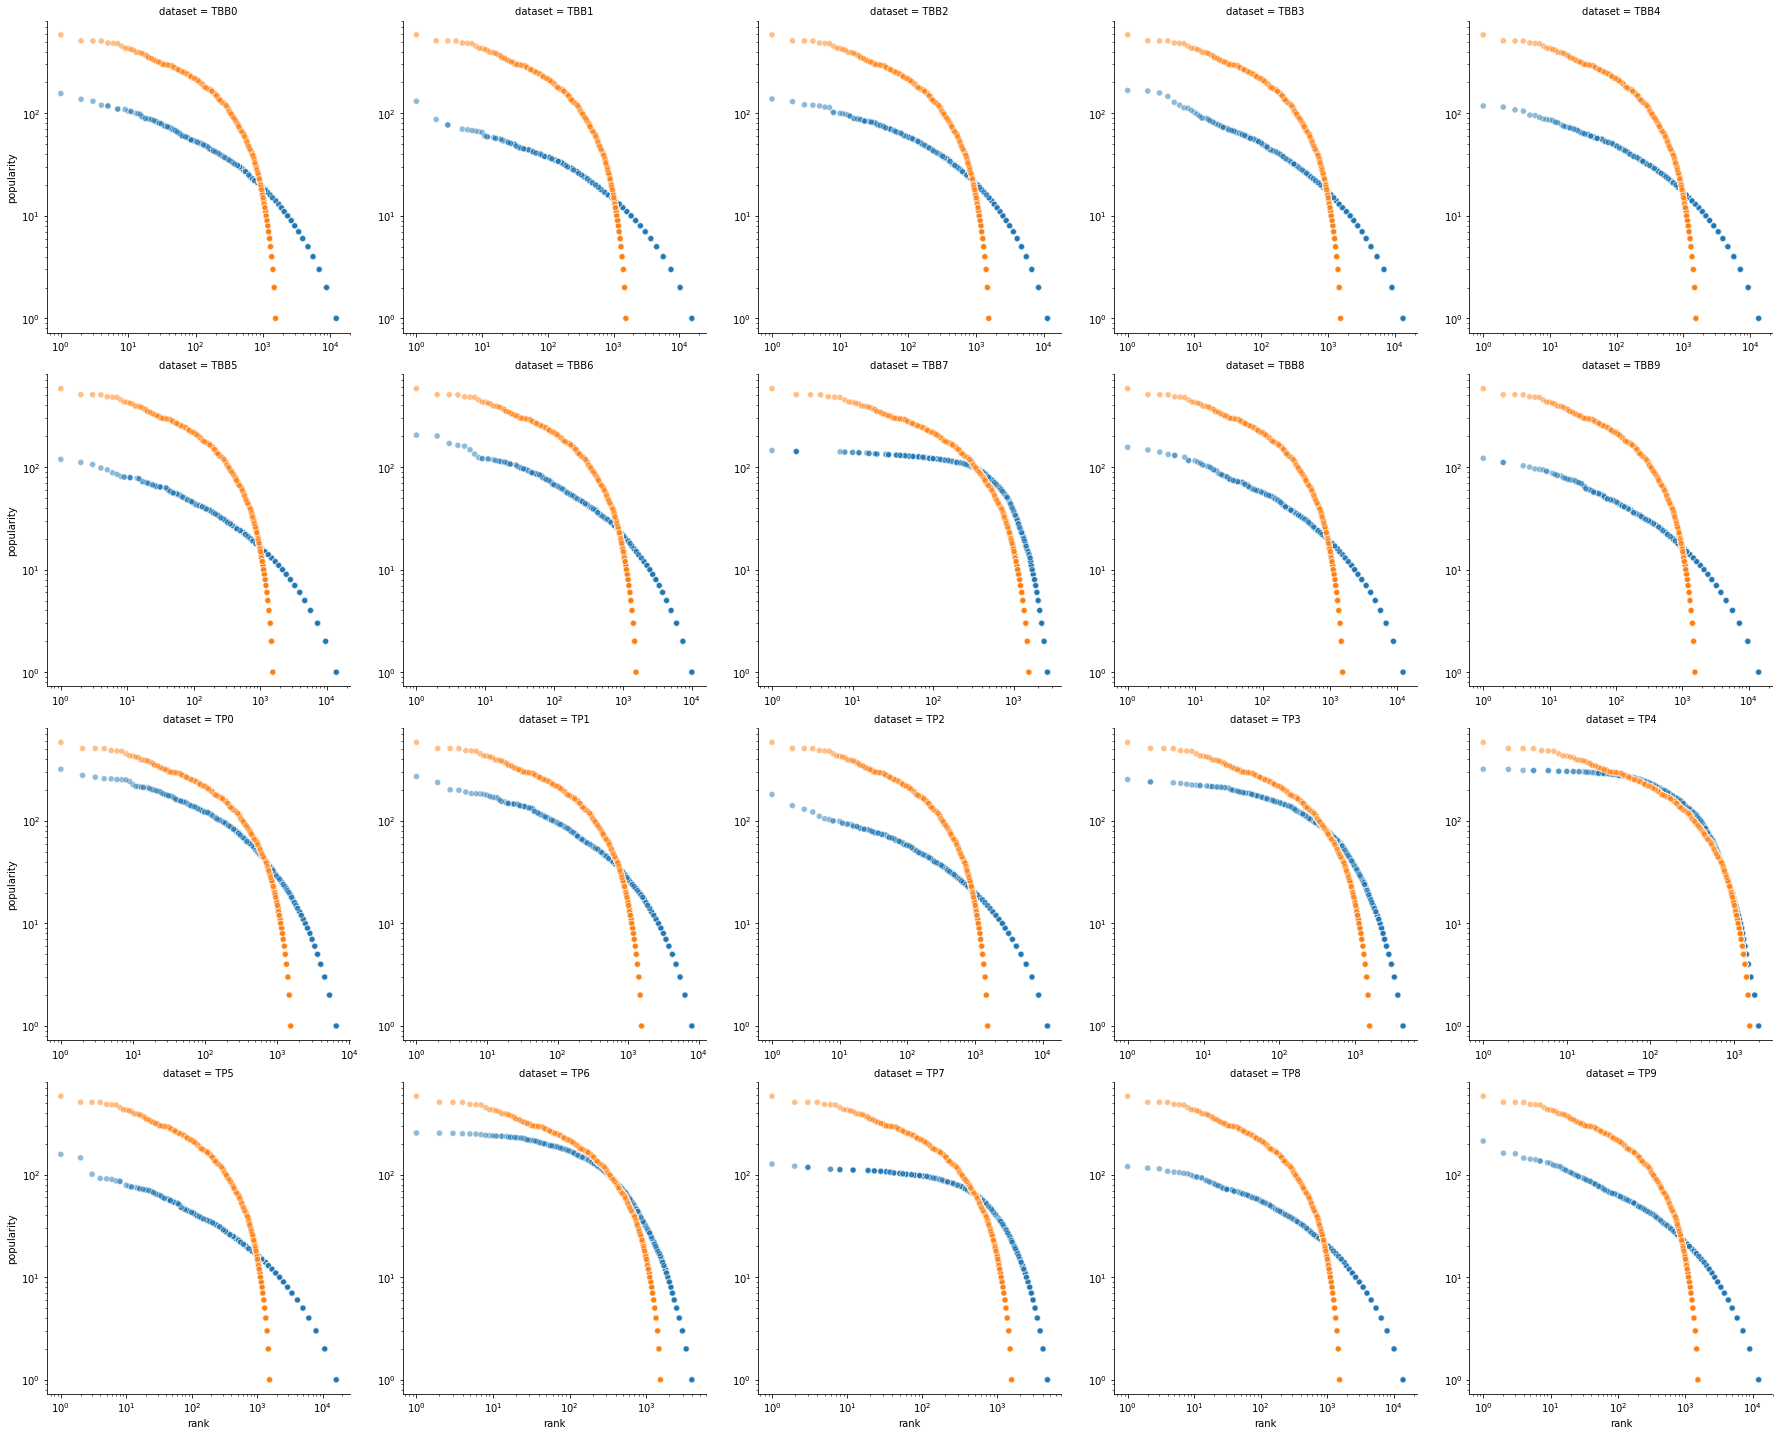

In [64]:
g = sns.FacetGrid(item_popularity_df, col='dataset', hue='dataset', sharex=False, sharey=False, col_wrap=5, height=5)
g = (g.map(plot_scatter_against_baseline, 'rank', 'count', hue='dataset', alpha=0.5, baseline=ml_100k_results[1])
     .set(xscale='log', yscale='log')
     .set_axis_labels('rank', 'popularity'))

In [65]:
popularity_counts = (item_popularity_df[['dataset', 'count']].groupby(['dataset', 'count'])
                     .size().reset_index().rename(columns={'count': 'popularity', 0: 'count'}))
ml_100k_pop_counts = (ml_100k_results[1][['dataset', 'count']].groupby(['dataset', 'count'])
                      .size().reset_index().rename(columns={'count': 'popularity', 0: 'count'}))

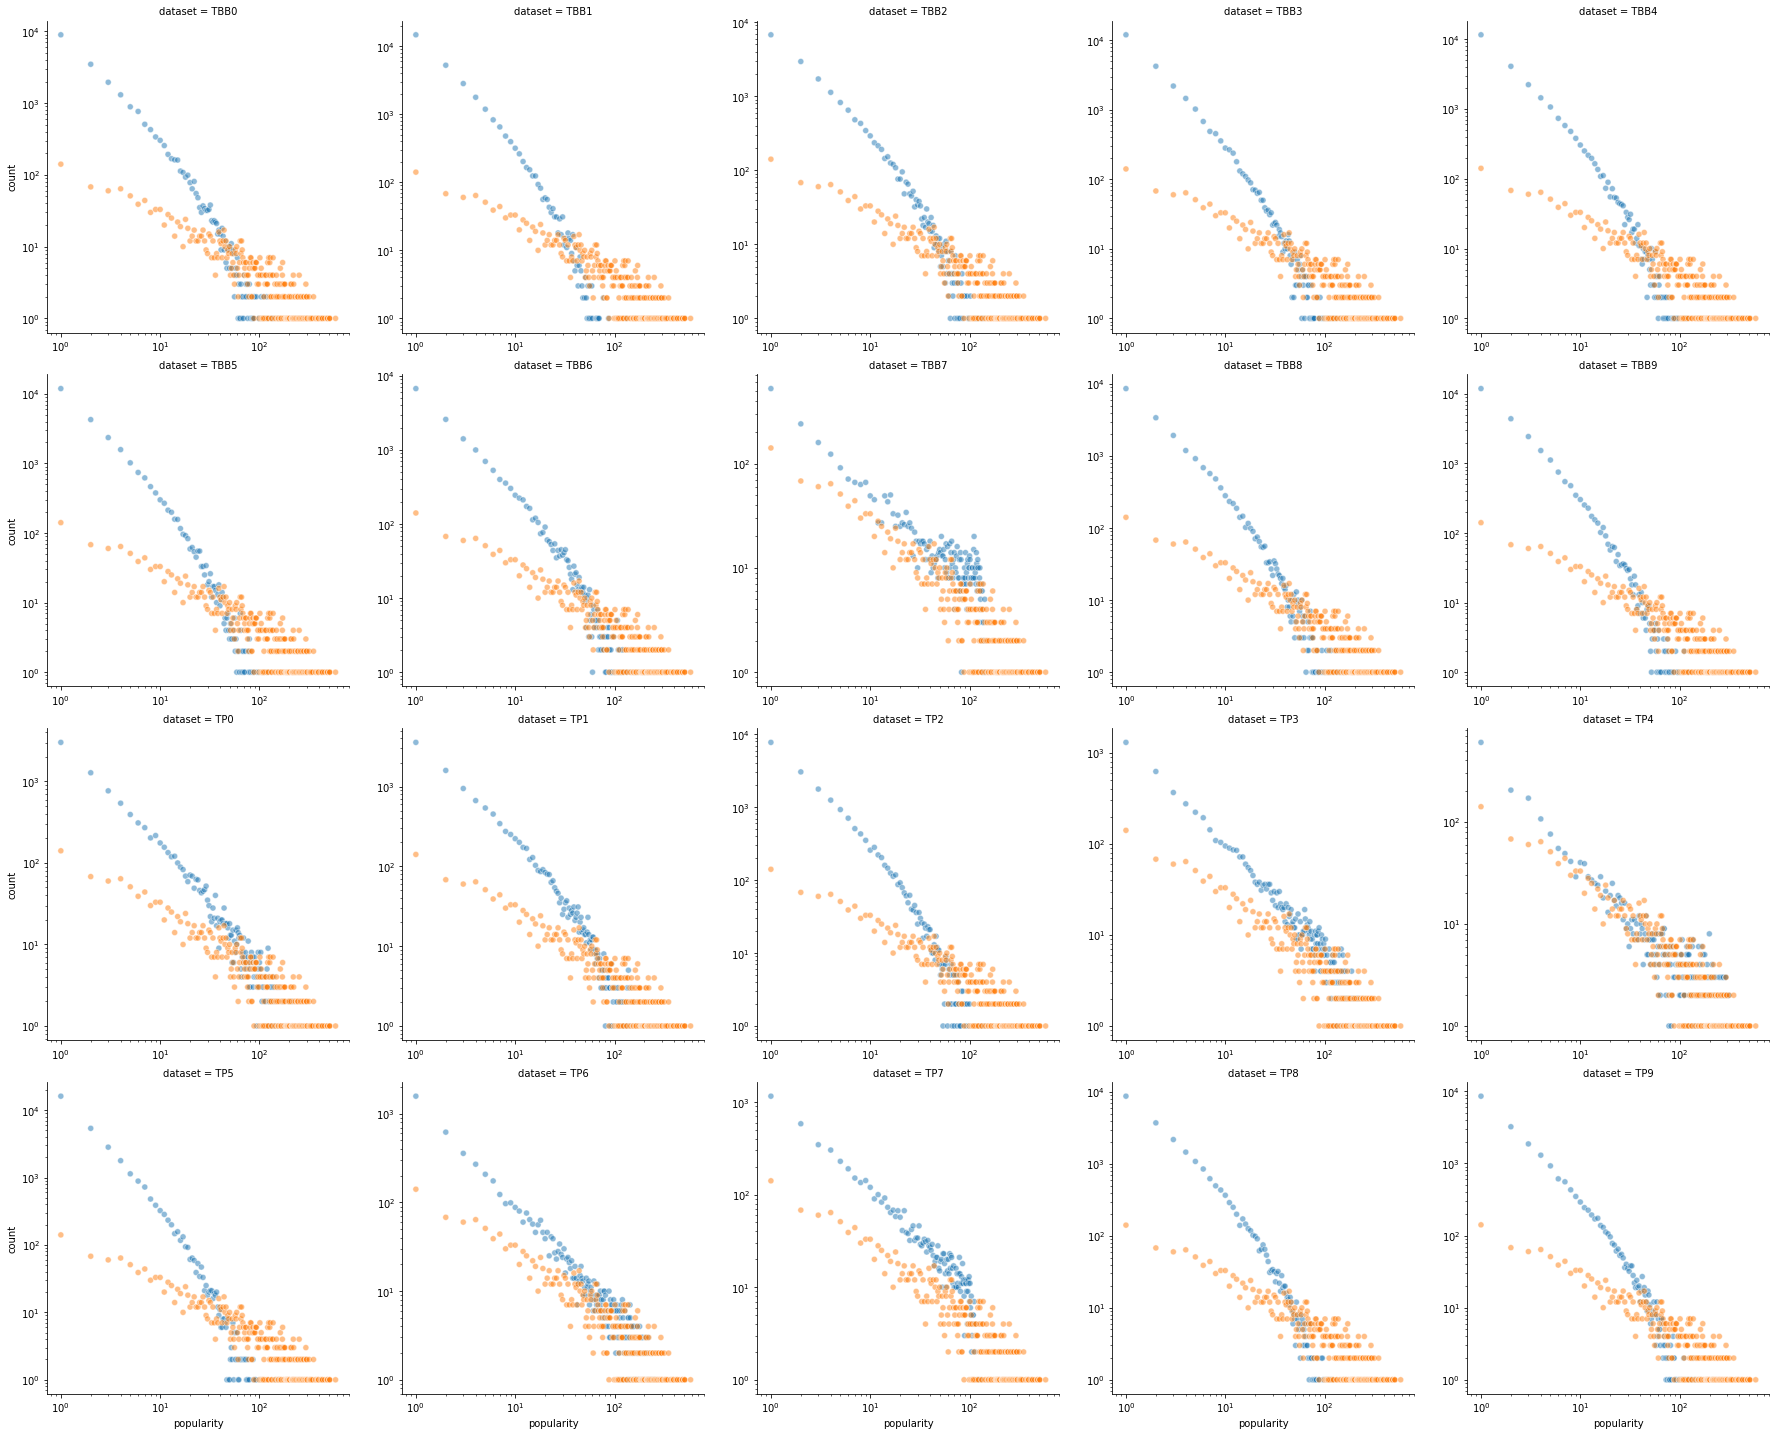

In [66]:
g = sns.FacetGrid(popularity_counts, col='dataset', hue='dataset', sharex=False, sharey=False, col_wrap=5, height=5)
g = (g.map(plot_scatter_against_baseline, 'popularity', 'count', hue='dataset', alpha=0.5, baseline=ml_100k_pop_counts)
     .set(xscale='log', yscale='log'))

#### Top10 parameters sorted by sum of squares of item popularity and user activity KL

In [67]:
ml_100k_results, user_profile_df, item_popularity_df = summarize_datasets(d_params)

dataset stats
    dataset  nusers  nitems  npairs   density
0   ml_100k     943    1682  100000  0.063047
1      TBB0     943    2125  101999  0.050901
2      TBB1     943    2436  101999  0.044402
3      TBB2     943    2077  101999  0.052077
4      TBB3     943    1890  101999  0.057230
5      TBB4     943    1886  101999  0.057351
6      TBB5     943    2089  101999  0.051778
7      TBB6     943    1925  101999  0.056189
8      TBB7     943    2073  101999  0.052178
9      TBB8     943    2000  101999  0.054082
10     TBB9     943    2649  101999  0.040832
11      TP0     943    2520  110311  0.046420
12      TP1     943    2174  110011  0.053662
13      TP2     943    2520  117771  0.049559
14      TP3     943    2809  114220  0.043120
15      TP4     943    2667  115874  0.046074
16      TP5     943    2529  110110  0.046171
17      TP6     943    2112  111618  0.056044
18      TP7     943    2614  109218  0.044307
19      TP8     943    2480  109995  0.047034
20      TP9     943 

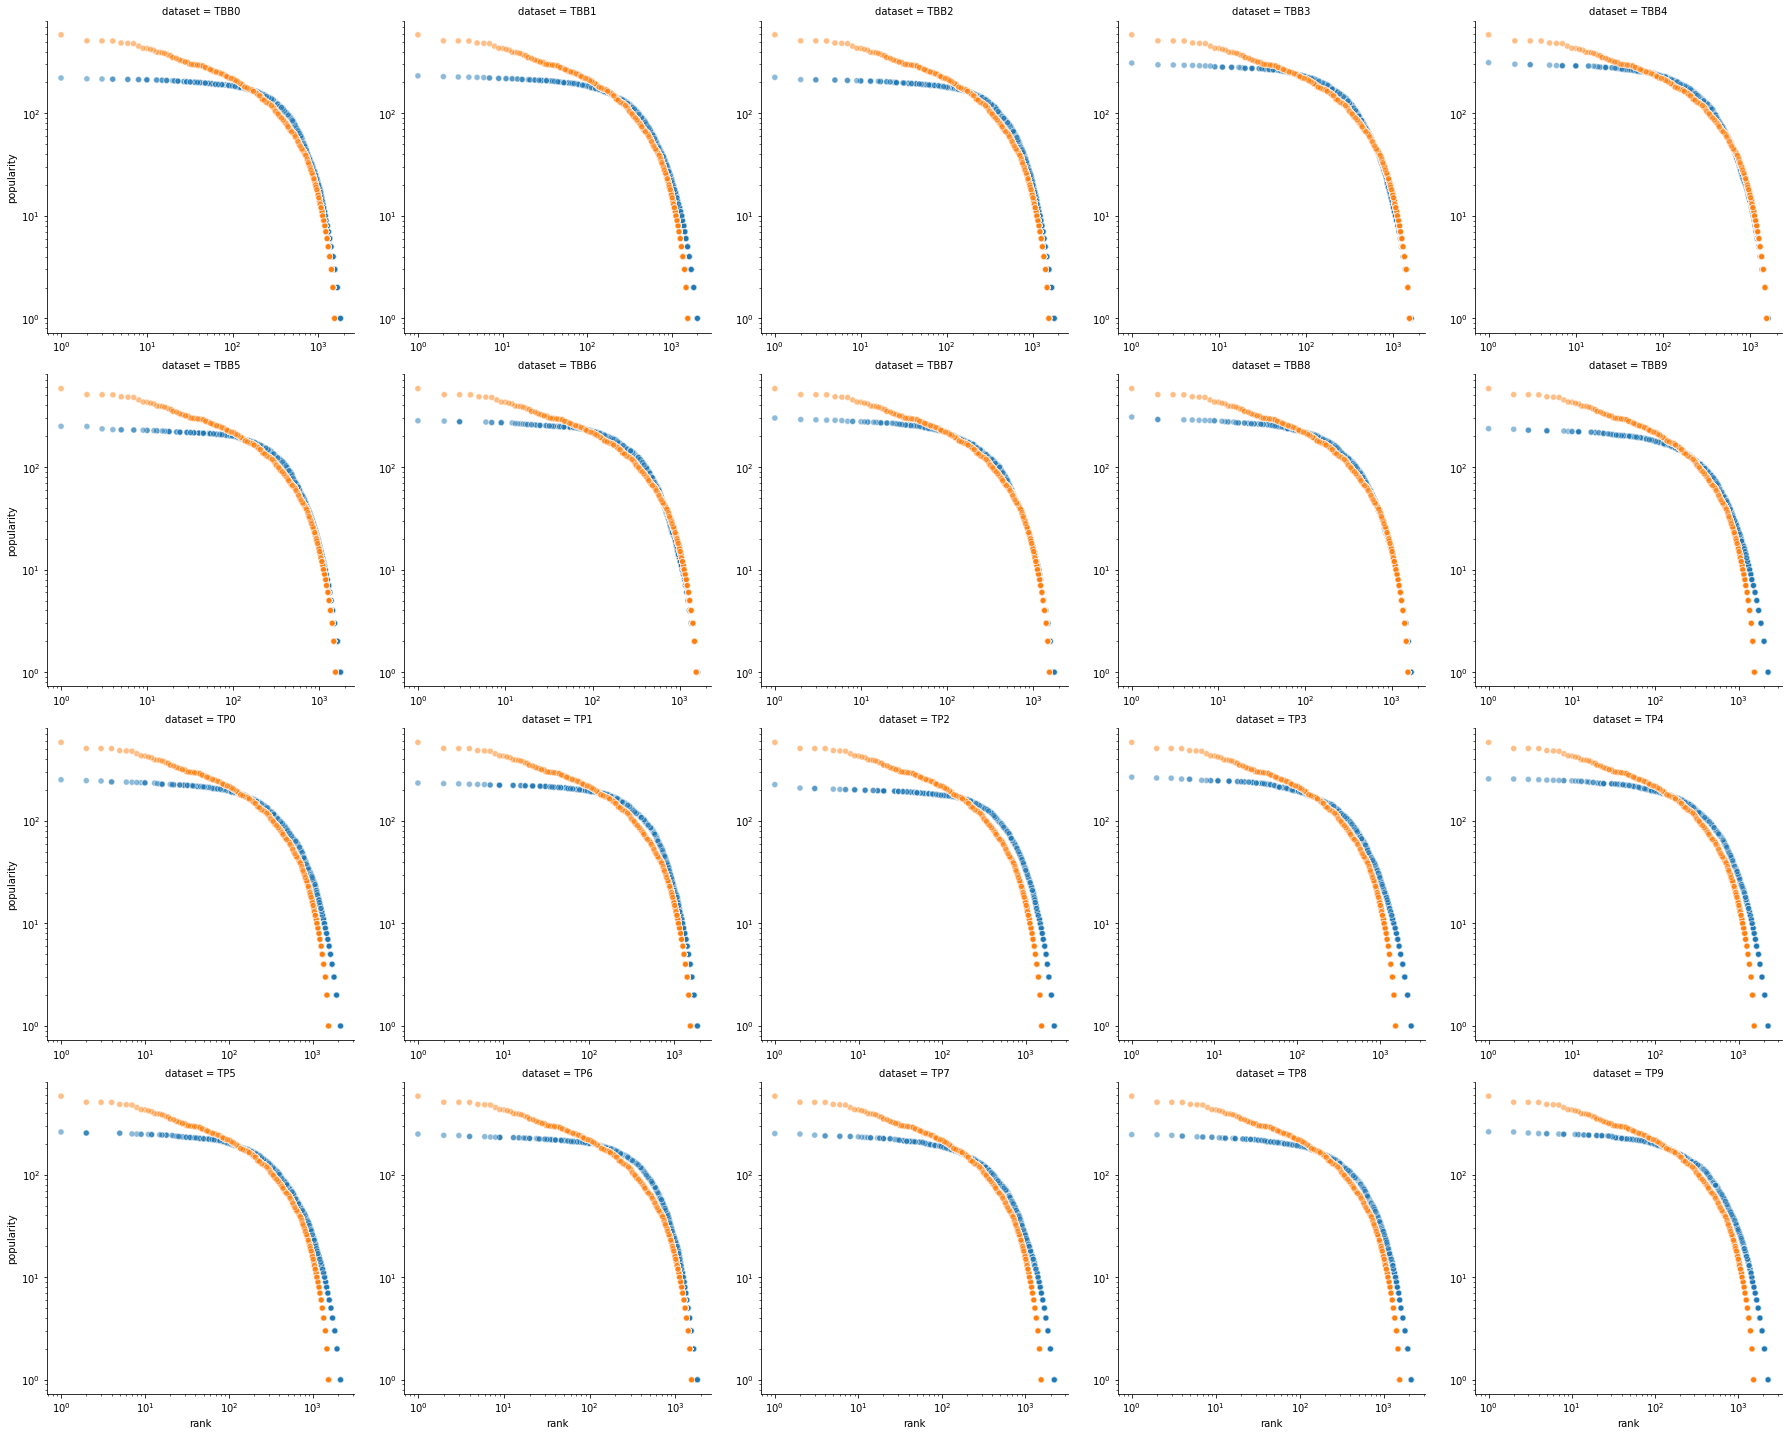

In [68]:
g = sns.FacetGrid(item_popularity_df, col='dataset', hue='dataset', sharex=False, sharey=False, col_wrap=5, height=5)
g = (g.map(plot_scatter_against_baseline, 'rank', 'count', hue='dataset', alpha=0.5, baseline=ml_100k_results[1])
     .set(xscale='log', yscale='log')
     .set_axis_labels('rank', 'popularity'))

In [69]:
popularity_counts = (item_popularity_df[['dataset', 'count']].groupby(['dataset', 'count'])
                     .size().reset_index().rename(columns={'count': 'popularity', 0: 'count'}))
ml_100k_pop_counts = (ml_100k_results[1][['dataset', 'count']].groupby(['dataset', 'count'])
                      .size().reset_index().rename(columns={'count': 'popularity', 0: 'count'}))

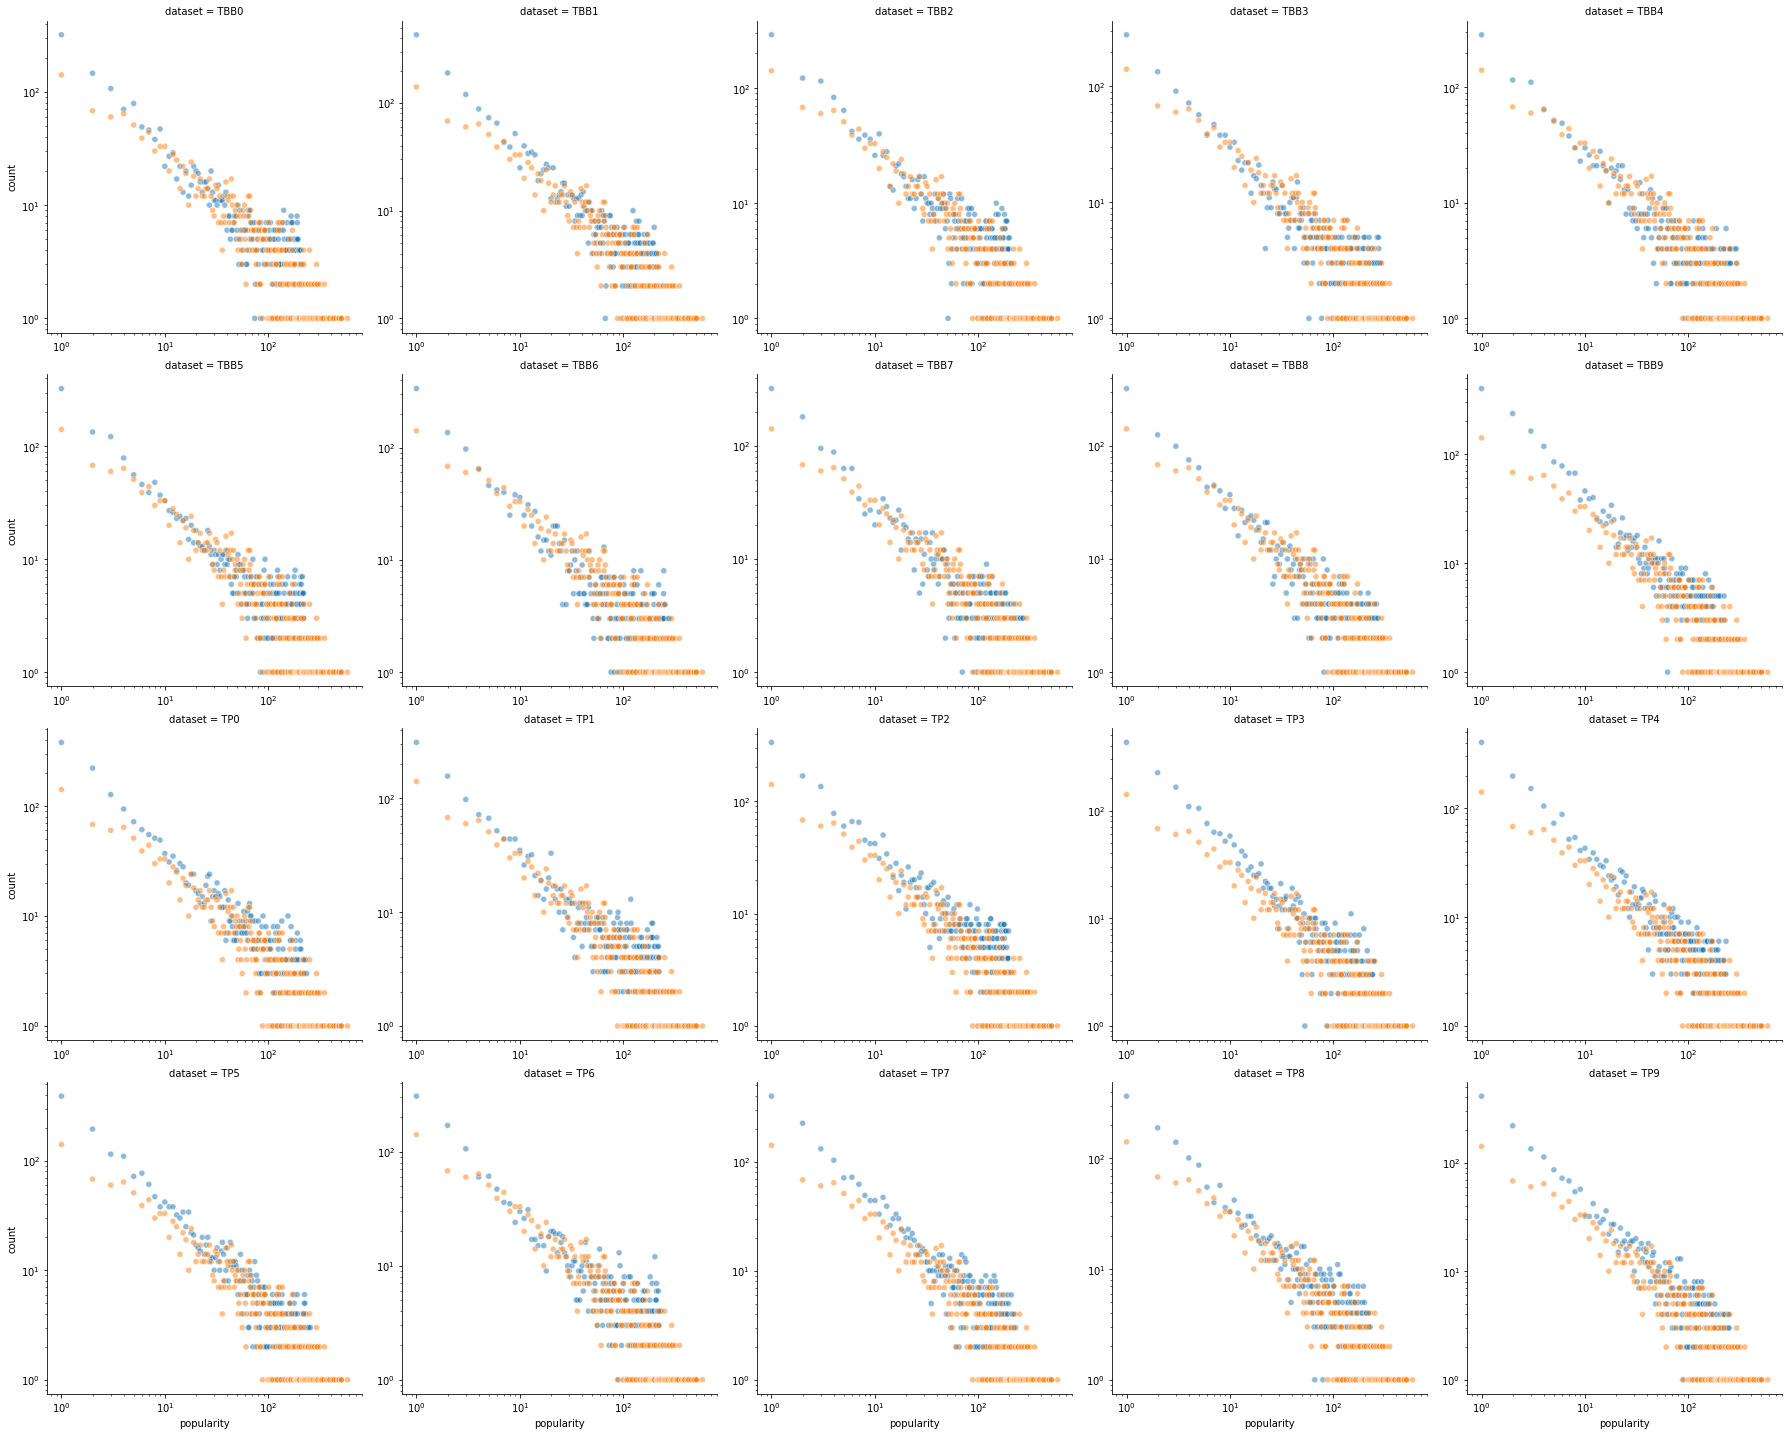

In [70]:
g = sns.FacetGrid(popularity_counts, col='dataset', hue='dataset', sharex=False, sharey=False, col_wrap=5, height=5)
g = (g.map(plot_scatter_against_baseline, 'popularity', 'count', hue='dataset', alpha=0.5, baseline=ml_100k_pop_counts)
     .set(xscale='log', yscale='log'))

In [55]:
user_profile_model1 = user_profile_df[user_profile_df['dataset'].isin(['ml_100k', 'simulated_beta_binomail'])].copy()
user_profile_model1['group'] = 1
user_profile_model2 = user_profile_df[user_profile_df['dataset'].isin(['ml_100k', 'simulated_pareto'])].copy()
user_profile_model2['group'] = 2
user_profile_models = pd.concat([user_profile_model1, user_profile_model2])

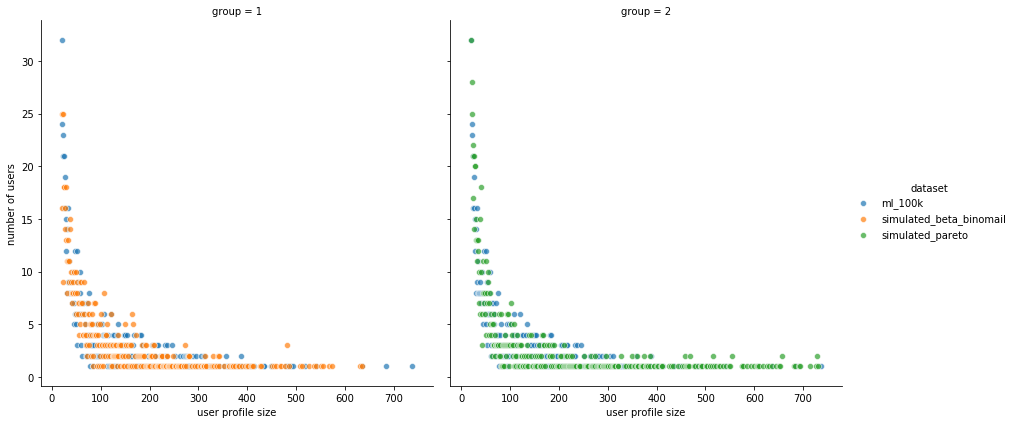

In [56]:
g = sns.FacetGrid(user_profile_models.groupby(['group', 'dataset', 'item'], as_index=False).count().sort_values(['group', 'dataset', 'item']), col='group', hue='dataset', height=6)
g = (g.map(sns.scatterplot, 'item', 'user', alpha=0.7)
     .add_legend()
     .set_axis_labels('user profile size', 'number of users'))

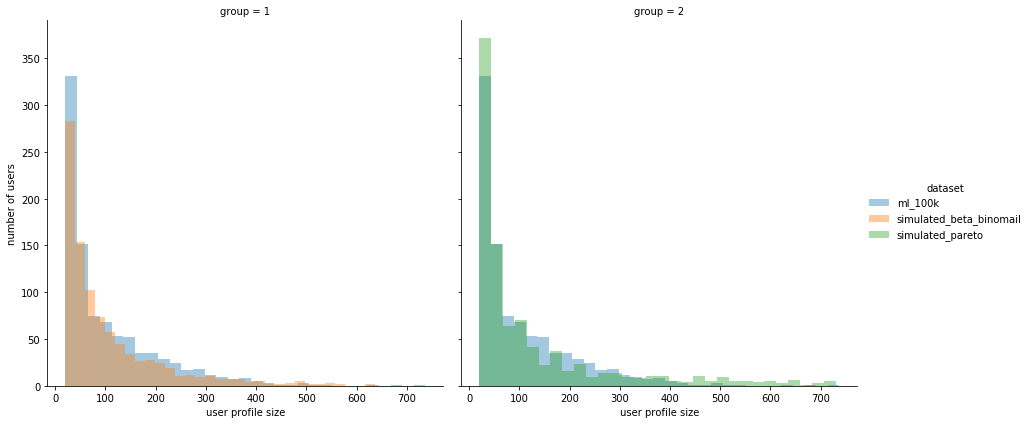

In [57]:
g = sns.FacetGrid(user_profile_models, col='group', hue='dataset', height=6)
g = (g.map(sns.distplot, 'item', kde=False)
     .add_legend()
     .set_axis_labels('user profile size', 'number of users'))
plt.show()

In [58]:
item_popularity_df.head()

item  user  dataset   rank
0     1   452  ml_100k    8.0
1     2   131  ml_100k  239.0
2     3    90  ml_100k  372.0
3     4   209  ml_100k  107.0
4     5    86  ml_100k  388.0

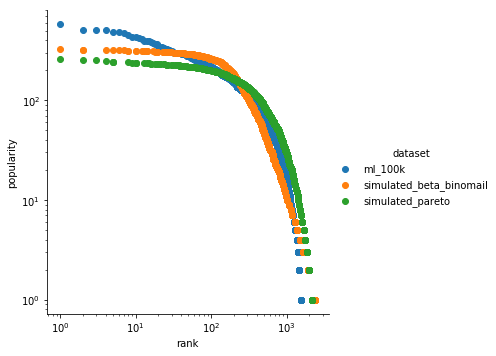

In [59]:
g = sns.FacetGrid(item_popularity_df, hue='dataset', height=5)
g = (g.map(plt.scatter, 'rank', 'user')
     .set(xscale='log', yscale='log')
     .set_axis_labels('rank', 'popularity')
     .add_legend())

In [60]:
count_popularity.head()

dataset  user  count
0  ml_100k     1    141
1  ml_100k     2     68
2  ml_100k     3     60
3  ml_100k     4     64
4  ml_100k     5     51

In [50]:
count_popularity_model1 = count_popularity[count_popularity['dataset'].isin(['ml_100k', 'simulated_beta_binomail'])].copy()
count_popularity_model1['group'] = 1
count_popularity_model2 = count_popularity[count_popularity['dataset'].isin(['ml_100k', 'simulated_pareto'])].copy()
count_popularity_model2['group'] = 2
count_popularity_models = pd.concat([count_popularity_model1, count_popularity_model2])

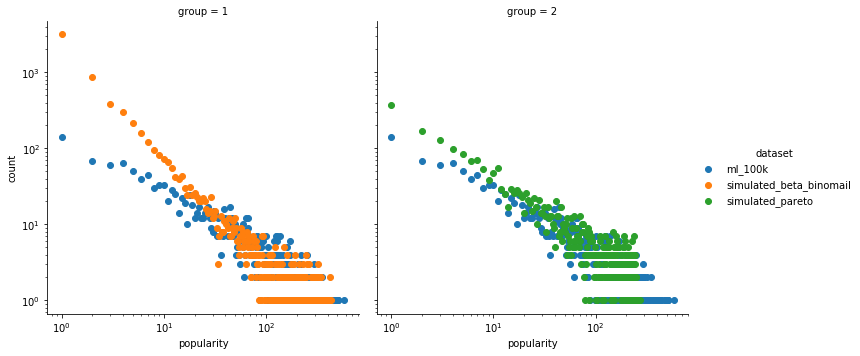

In [51]:
g = sns.FacetGrid(count_popularity_models, col='group', hue='dataset', height=5)
g = (g.map(plt.scatter, 'user', 'count')
     .set(xscale='log', yscale='log')
     .set_axis_labels('popularity', 'count').add_legend())

In [246]:
from scipy.stats import entropy

In [247]:
tall_popularity_count = count_popularity_model1.pivot_table(index='user', columns='dataset', values='count')

In [248]:
p = np.ones(max(tall_popularity_count['ml_100k'].dropna().index))

In [249]:
p[tall_popularity_count['ml_100k'].dropna().index.values - 1] += tall_popularity_count['ml_100k'].dropna().values

In [250]:
p /= p.sum()

In [251]:
q = np.ones(max(tall_popularity_count['simulated_beta_binomail'].dropna().index))

In [252]:
q[tall_popularity_count['simulated_beta_binomail'].dropna().index.values - 1] += tall_popularity_count['simulated_beta_binomail'].dropna().values

In [253]:
q /= q.sum()

In [254]:
lb = min(len(q), len(p))

In [255]:
entropy(q[:lb], p[:lb])

0.09075708186382384

In [256]:
tall_popularity_count = count_popularity_model1.pivot_table(index='user', columns='dataset', values='count', fill_value=0)

In [257]:
p = tall_popularity_count['ml_100k'] + 1

In [258]:
p /= p.sum()

In [259]:
q = tall_popularity_count['simulated_beta_binomail'] + 1

In [260]:
q /= q.sum()

In [261]:
entropy(q, p)

0.23545846119972072